#### Loading train and predictions files

In [67]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

df_train = pd.read_csv("train.csv")
df_predictions = pd.read_csv("predictions.csv")

### dropping unnamed att
df_train.drop('Unnamed: 0', axis = 1, inplace = True)
df_predictions.drop('Unnamed: 0', axis = 1, inplace = True)

### The city name should lead to bias, so let's remove it, but keep them for further analysis
citiesWithStores = df_train['CITY'].to_frame()
cityNamesPredictions = df_predictions['CITY'].to_frame()
df_train.drop('CITY', axis = 1, inplace = True)
df_predictions.drop('CITY', axis = 1, inplace = True)




In [68]:
### just to be sure
display(df_train.head())
display(df_predictions.head())
display(cityNamesPredictions.head())

,2010 Census,Land Area,Households with Under 18,Population Density,Total Families,Total Pawdacity Sales
0,4585,3115.50750,746,1.55,1819.50,185328
1,35316,3894.30910,7788,11.16,8756.32,317736
2,9520,2998.95696,1403,1.82,3515.62,218376
3,6120,1829.46510,832,1.46,1744.08,208008
4,12359,999.49710,1486,4.95,2712.64,283824


,2010 Census,Land Area,Households with Under 18,Population Density,Total Families
0,1911,853.806650,497,0.93,1040.41
1,181,7.685902,37,0.10,74.87
2,828,366.598892,213,0.40,446.72
3,440,253.240322,62,0.06,129.53
4,106,29.459830,18,0.01,33.70


,CITY
0,Afton
1,Albin
2,Alpine
3,Baggs
4,Bairoil


#### Looking at the distribution

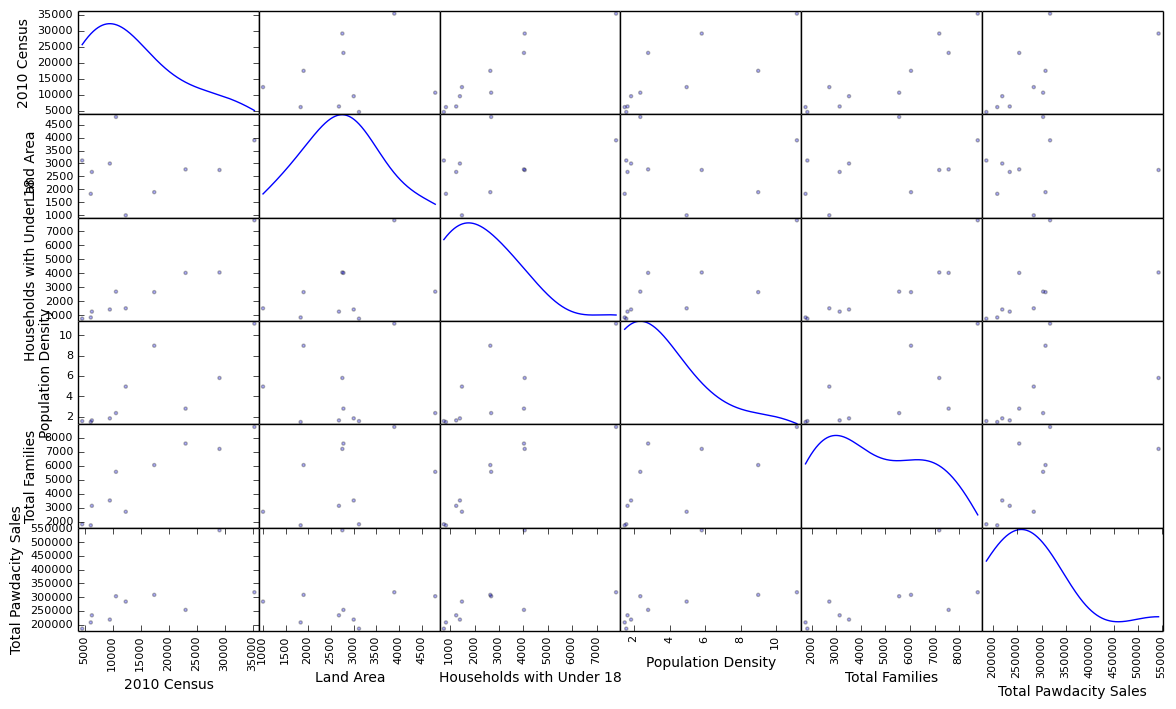

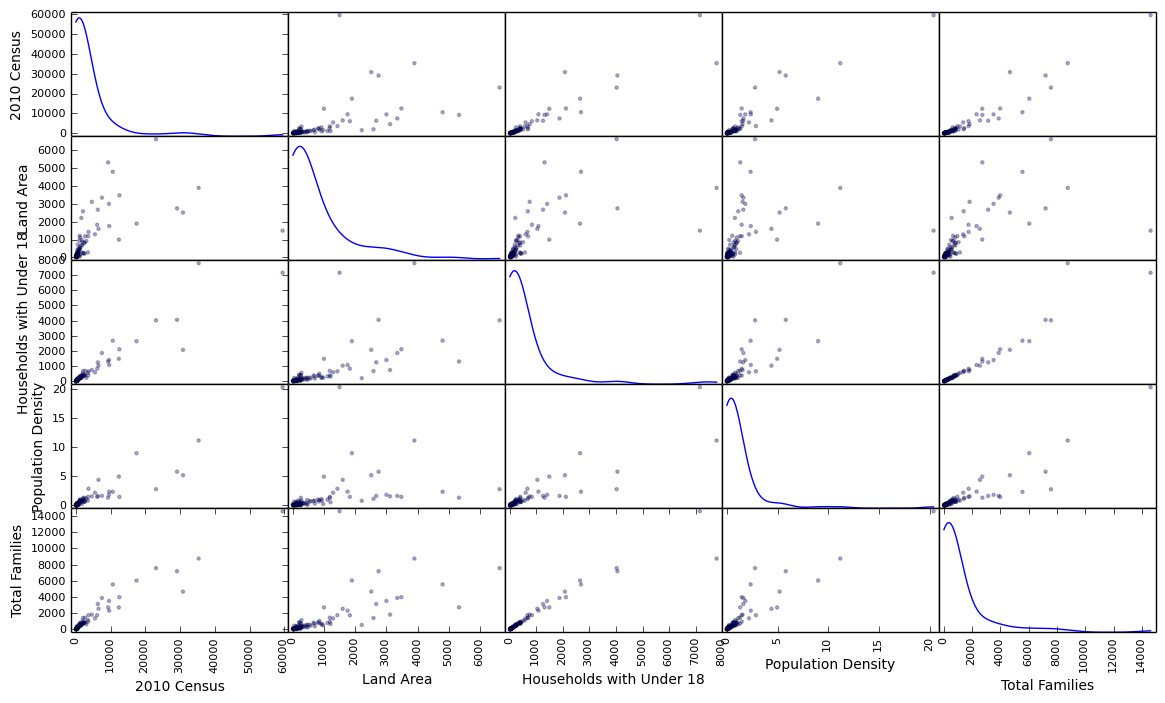

In [69]:
pd.scatter_matrix(df_train, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
pd.scatter_matrix(df_predictions, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

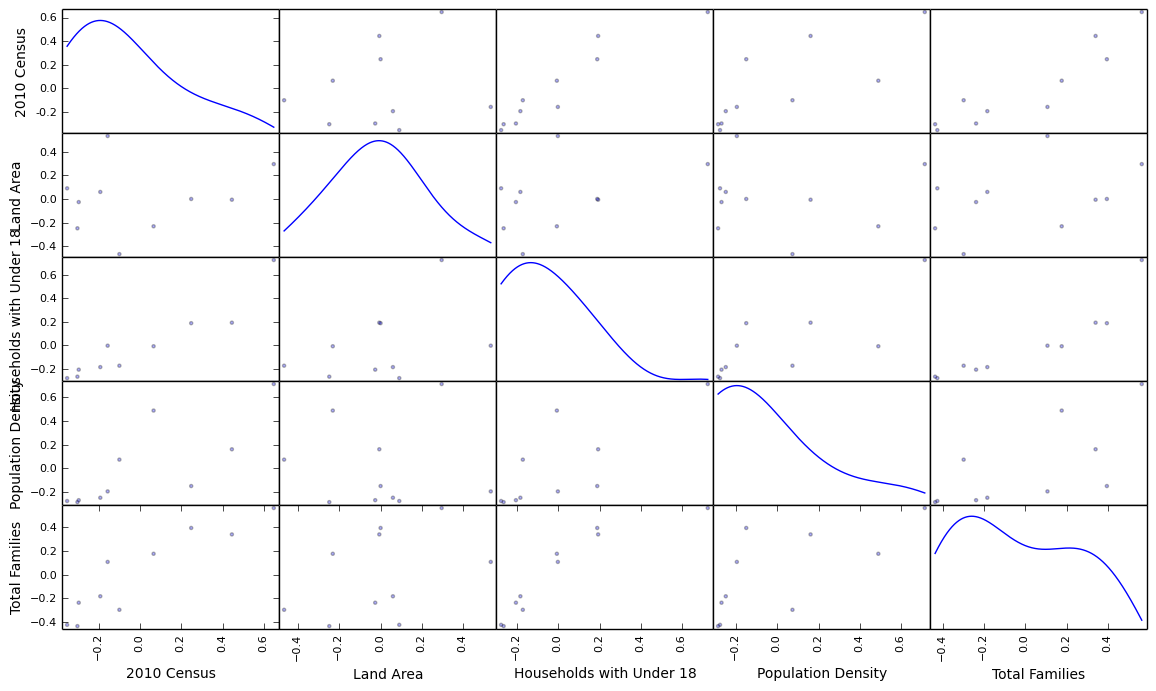

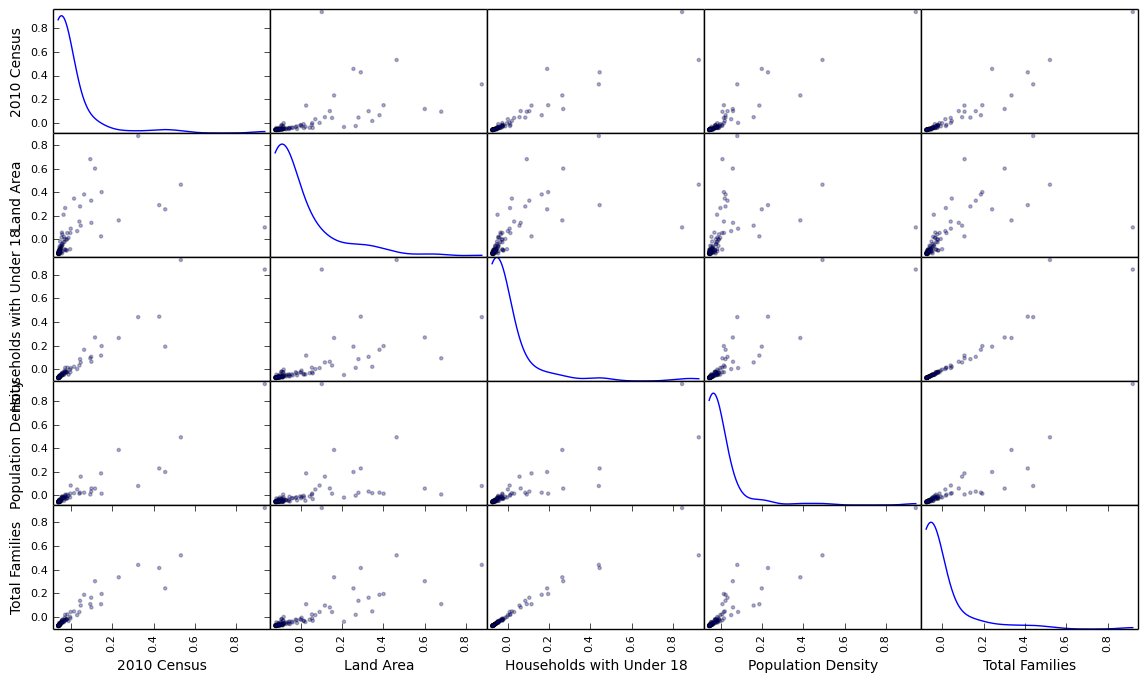

In [70]:
### Breaking data down into X and Y
X = df_train.drop('Total Pawdacity Sales', axis = 1)
Y = df_train['Total Pawdacity Sales']

### Normalizing both X, and df_predictions
cols_to_norm = ['2010 Census','Land Area', 'Households with Under 18', 'Population Density', 'Total Families']
X[cols_to_norm] = X[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
df_predictions[cols_to_norm] = df_predictions[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))


pd.scatter_matrix(X, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
pd.scatter_matrix(df_predictions, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [71]:
#### Learning a linear model
from sklearn.linear_model import LinearRegression

# reg = LinearRegression(fit_intercept = True)
reg = LinearRegression()
reg.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Compute the p-values and r^2 values

In [72]:
from sklearn.feature_selection import f_regression
_, pvalues = f_regression(X, Y)
index = 0
for attribute in X.columns.values:
    pval = pvalues[index]
    print "{} has a p-value of {}".format(attribute, pval)
    index = index + 1




from sklearn.metrics import r2_score
predictions_train = reg.predict(X)
r2score = r2_score(predictions_train, Y)
print "\n\tThe r2 score obtained during training is {:.5f}".format(r2score)
# for att in X.columns.values:
#     r2_var = r2_score(X[att], Y)
#     pval = 0.0
#     print "{} has a r2 score of {:.5f} and a p-value of {}".format(att, r2_var, pval)

2010 Census has a p-value of 0.0297405639802
Land Area has a p-value of 0.827370746068
Households with Under 18 has a p-value of 0.147198735719
Population Density has a p-value of 0.154362637486
Total Families has a p-value of 0.062851610687

	The r2 score obtained during training is 0.78327


#### Printing out the equation

In [73]:
indexCoef = 0
coefficients = reg.coef_
finalEquation = "Y = "
for attribute in X.columns.values:
    coef = coefficients[indexCoef]
    finalEquation = finalEquation + "{:0.2f} * {} + ".format(float(coef), attribute)
    indexCoef = indexCoef + 1
finalEquation = finalEquation + "{0:.2f}".format(float(reg.intercept_))
print finalEquation

Y = 919993.38 * 2010 Census + 264592.01 * Land Area + -917791.12 * Households with Under 18 + 104914.76 * Population Density + -76837.20 * Total Families + 285541.20


#### Applying the model to the predictions file

In [74]:
predictions = reg.predict(df_predictions)
# print predictions.shape
# print cityNamesPredictions.shape
# print type(predictions)
# print type(cityNamesPredictions)
cityNamesPredictions['Predictions'] = predictions
# print cityNamesPredictions.shape
display(cityNamesPredictions.head())

,CITY,Predictions
0,Afton,268625.789284
1,Albin,263022.047388
2,Alpine,266239.624808
3,Baggs,273413.971357
4,Bairoil,264724.689506


#### Filtering results given project criteria

1. The new store should be located in a new city. That means there should be no existing stores in the new city.
2. The total sales for the entire competition in the new city should be less than 500,000

3. The new city where you want to build your new store must have a population over 4,000 people (based upon the 2014 US Census estimate).

4. The predicted yearly sales must be over 200,000.

5. The city chosen has the highest predicted sales from the predicted set.

In [75]:
### I will need some more data here... So let's load and work on the datasets that have the info we need :)

df_demographic = pd.read_csv("demographic_data.csv")
df_demographic.drop('Unnamed: 0', axis = 1, inplace = True)
df_web_scrape = pd.read_csv("web_scrape.csv")
df_web_scrape.drop('Unnamed: 0', axis = 1, inplace = True)
df_naics = pd.read_csv("naics_data.csv")
df_naics['CITY'] = df_naics['PHYSICAL CITY NAME']
df_naics.drop('PHYSICAL CITY NAME', axis = 1, inplace = True)
df_naics.drop('Unnamed: 0', axis = 1, inplace = True)
df_naics = df_naics.groupby('CITY').sum().reset_index()

# display(df_demographic.head())
# display(df_web_scrape.head())
### time to join 'em all!
df_joined = df_demographic.join(df_web_scrape.set_index('CITY'), on = "CITY", how = "inner")
df_joined = df_joined.join(df_naics.set_index('CITY'), on = "CITY", how = "inner")
df_joined = df_joined.join(cityNamesPredictions.set_index('CITY'), on = "CITY", how = "inner")
display(df_joined.head())


,CITY,Land Area,Households with Under 18,Population Density,Total Families,2014 Estimate,2010 Census,SALES VOLUME,Predictions
2,Alpine,366.598892,213,0.40,446.72,845,828,70000,266239.624808
13,Casper,3894.309100,7788,11.16,8756.32,40086,35316,210000,59890.997274
14,Cheyenne,1500.178400,7158,20.34,14612.64,62845,59466,1021000,428570.857329
24,Douglas,1829.465100,832,1.46,1744.08,6423,6120,96000,332331.795374
25,Dubois,437.073505,244,0.21,506.29,998,971,55000,266324.011388


In [76]:
df_joined.sort_values(by = "Predictions", axis=0, ascending=False, inplace=True, kind='quicksort')
display(df_joined.head())

,CITY,Land Area,Households with Under 18,Population Density,Total Families,2014 Estimate,2010 Census,SALES VOLUME,Predictions
52,Laramie,2513.745235,2075,5.19,4668.93,32081,30816,76000,599149.862111
14,Cheyenne,1500.178400,7158,20.34,14612.64,62845,59466,1021000,428570.857329
79,Rock Springs,6620.201916,4022,2.78,7572.18,24045,23036,990000,385877.201978
45,Jackson,1757.659200,1078,2.36,2313.08,10449,9577,182000,355598.735970
33,Gillette,2748.852900,4052,5.80,7189.43,31971,29087,1130000,338652.612667


#### Looks good enough now, so let's filter the results to match our constraints!

In [77]:
#1. The new store should be located in a new city. That means there should be no existing stores in the new city.
#2. The total sales for the entire competition in the new city should be less than 500,000
#3. The new city where you want to build your new store must have a population over 4,000 people (based upon the 2014 US Census estimate).
#4. The predicted yearly sales must be over 200,000.
#5. The city chosen has the highest predicted sales from the predicted set.
maskNewCity = (~df_joined['CITY'].isin(citiesWithStores))
maskTotalSalesCompetition = (df_joined['SALES VOLUME'] < 500000)
maskPopulation = (df_joined['2014 Estimate'] > 4000)
maskYearlySales = (df_joined['Predictions'] > 200000)
df_masked = df_joined.loc[maskNewCity & maskTotalSalesCompetition & maskPopulation & maskYearlySales] #  
display(df_masked)

,CITY,Land Area,Households with Under 18,Population Density,Total Families,2014 Estimate,2010 Census,SALES VOLUME,Predictions
52,Laramie,2513.745235,2075,5.19,4668.93,32081,30816,76000,599149.862111
45,Jackson,1757.659200,1078,2.36,2313.08,10449,9577,182000,355598.735970
96,Worland,1294.105755,595,2.18,1364.32,5366,5487,169000,334766.445832
24,Douglas,1829.465100,832,1.46,1744.08,6423,6120,96000,332331.795374
29,Evanston,999.497100,1486,4.95,2712.64,12190,12359,89000,331474.993529
51,Lander,3346.809340,1870,1.63,3876.81,7642,7487,152197,281498.645841
